2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
Epoch 0, D Loss: 1.513502597808838, G Loss: [array(0.7993444, dtype=float32), array(0.7993444, dtype=float32), array(0.09375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


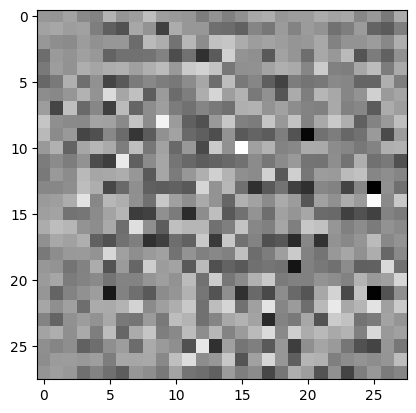

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and Preprocess MNIST Data
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train.astype('float32') / 255.0).reshape(-1, 28, 28, 1)

latent_dim = 100
img_shape = (28, 28, 1)
batch_size = 64
epochs = 10000

# 2. Build the Encoder, Generator, and Discriminator
def build_encoder():
    model = tf.keras.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(32, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(latent_dim)
    ])
    return model

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 64),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')
    ])
    return model

def build_discriminator():
    img_input = layers.Input(shape=img_shape)
    latent_input = layers.Input(shape=(latent_dim,))

    img_model = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(img_input)
    img_model = layers.LeakyReLU()(img_model)
    img_model = layers.Flatten()(img_model)

    combined = layers.Concatenate()([img_model, latent_input])

    validity = layers.Dense(1, activation='sigmoid')(combined)

    model = tf.keras.Model([img_input, latent_input], validity)
    return model

# 3. Build and Compile the Models
encoder = build_encoder()
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. BiGAN model (encoder + generator)
latent_input = layers.Input(shape=(latent_dim,))
generated_img = generator(latent_input)
reconstructed_latent = encoder(generated_img)
validity = discriminator([generated_img, latent_input])

bigan_model = tf.keras.Model(latent_input, validity)
bigan_model.compile(optimizer='adam', loss='binary_crossentropy')

# 5. Training the BiGAN
for epoch in range(epochs):
    # Random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Random latent vectors
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_imgs = generator.predict(latent_vectors)

    # Get latent representations of real images
    real_latent = encoder.predict(real_imgs)

    # Real and fake labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_imgs, real_latent], real_labels)
    d_loss_fake = discriminator.train_on_batch([generated_imgs, latent_vectors], fake_labels)

    # Train the generator+encoder (BiGAN)
    g_loss = bigan_model.train_on_batch(latent_vectors, real_labels)

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, D Loss: {d_loss_real[0] + d_loss_fake[0]}, G Loss: {g_loss}')

    # Display generated images periodically
    if epoch % 5000 == 0:
        # Generate images and display
        latent_vec = np.random.normal(size=(1, latent_dim))
        generated_img = generator.predict(latent_vec)
        plt.imshow(generated_img[0].reshape(28, 28), cmap='gray')
        plt.show()
